# Todo

- fix the laser size using dynamical prog
- fix constituent_end and start
- run plotting.py & decode.py to test the new way of handling epochs
- try different decodings with Hydra configuration
- add Hydra configuration to plotting.py

# Initial Plotting for ERPs

### #1
First plot: 3x2 plot, that shows:
- From the onset, and offset of {word, constituent, sentence}:

The evoked potential linked to it, as well as the decoding of the word embedding

In [1]:
from dataset import read_raw, get_subjects, get_path, mne_events
from utils import decod_xy
import mne
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import match_list

all_evos = []
all_scores = []

path = get_path("LPP_read")
subjects = get_subjects(path)
task = "read"
# Debug
run = 1


for subject in subjects:
   raw, meta, events = read_raw(subject, run, events_return = True)
   for start in ('onset', 'offset'): 
      for level in ('word', 'constituent', 'sentence'):
         # Word start
         meta['word_onset'] = True

         # I don't really understand what to do here.. nothing for the moment
         # But I guess it will make sense once we introduce the baseline
         # Word end
         meta['word_offset'] = True

         # Sent start
         meta['sentence_onset'] = meta.word_id == 0

         # Sent stop
         meta['next_word_id'] = meta['word_id'].shift(-1)
         meta['sentence_offset'] = meta.apply(lambda x: True if x['word_id'] > x['next_word_id'] else False, axis=1)
         meta['sentence_offset'].fillna(False, inplace=True)
         meta.drop('next_word_id', axis=1, inplace=True)

         # Const start
         meta['prev_closing'] = meta['n_closing'].shift(1)
         meta['constituent_onset'] = meta.apply(lambda x: True if x['prev_closing'] > x['n_closing'] and x['n_closing'] == 1 else False, axis=1)
         meta['constituent_onset'].fillna(False, inplace=True)
         meta.drop('prev_closing', axis=1, inplace=True)

         # Const stop
         meta['next_closing'] = meta['n_closing'].shift(-1)
         meta['constituent_offset'] = meta.apply(lambda x: True if x['n_closing'] > x['next_closing'] else False, axis=1)
         meta['constituent_offset'].fillna(False, inplace=True)
         meta.drop('next_closing', axis=1, inplace=True)

         # Select only the rows containing the True for the conditions (sentence_end, etc..)
         sel = meta.query(f'{level}_{start}==True')

         # Matchlist events and meta
         # So that we can epoch now that's we've sliced our metadata
         i, j = match_list(events[:, 2], sel.word.apply(len))
         sel = sel.reset_index().loc[j]
         epochs = mne.Epochs(raw, **mne_events(sel, raw), event_repeated = 'drop')  # n_words OR n_constitutent OR n_sentences
         
         # mean
         evo = epochs.copy().load_data().pick_types(meg=True).average(method='median').get_data()
      
         # decoding word emb
         import spacy
         nlp = spacy.load("fr_core_news_sm")
         epochs = epochs.load_data().pick_types(meg=True, stim=False, misc=False)
         X = epochs.get_data()
         embeddings = epochs.metadata.word.apply(lambda word: nlp(word).vector).values
         embeddings = np.array([emb for emb in embeddings])
         R_vec = decod_xy(X, embeddings)
         scores = np.mean(R_vec, axis=1)

         for t, score in enumerate(scores):
            all_evos.append(dict(subject=subject, evo=evo, start=start, level=level, t=epochs.times[t]))
            all_scores.append(dict(subject=subject, score=score, start=start, level=level, t=epochs.times[t]))

all_scores = pd.DataFrame(all_scores)

fig, axes = plt.subplots(3, 2)

for axes_, start in zip(axes, ('onset', 'offset')):
    for ax, level in zip( axes_, ('word', 'constituent', 'sentence')):
       
       sns.lineplot(ax=ax, x='times', y='score', data=all_scores.query('start==@start, level==@level'))




 Epoching for run 1, subject: 3

Opening raw data file /home/co/data/BIDS_lecture/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 36000 ... 517999 =     36.000 ...   517.999 secs
Ready.
Reading events from /home/co/data/BIDS_lecture/sub-3/ses

/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Omitted 81 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Trigger channel has a non-zero initial value of 8 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1466 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Reading 0 ... 481999  =      0.000 ...   481.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.4s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 20 columns
1410 matching events found
-0.2 1000.0
<class 'float'> <class 'float'>
-200.0
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1410 events and 701 original time points ...


/tmp/ipykernel_83560/4247511903.py:60: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw), event_repeated = 'drop')  # n_words OR n_constitutent OR n_sentences


1 bad epochs dropped
Using data from preloaded Raw for 1410 events and 701 original time points ...
1 bad epochs dropped
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

KeyError: '[0, 1, 2, 3, 5, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 33, 34, 35, 37, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 53, 54, 55, 57, 59, 60, 62, 63, 64, 65, 66, 67, 69, 70, 71, 73, 74, 75, 76, 77, 79, 80, 81, 83, 85, 86, 87, 88, 90, 92, 93, 95, 96, 97, 99, 101, 102, 103, 105, 106, 107, 108, 110, 111, 112, 113, 115, 116, 118, 119, 121, 122, 123, 124, 125, 126, 127, 129, 131, 133, 134, 136, 138, 139, 140, 141, 143, 145, 146, 148, 149, 150, 152, 154, 155, 156, 157, 159, 161, 163, 164, 165, 166, 167, 169, 170, 171, 172, 174, 176, 178, 180, 181, 182, 183, 185, 186, 188, 189, 190, 191, 192, 193, 195, 197, 199, 200, 201, 203, 204, 205, 206, 208, 209, 210, 211, 213, 214, 215, 216, 218, 219, 221, 222, 223, 224, 225, 226, 228, 229, 230, 231, 232, 234, 235, 237, 239, 241, 243, 244, 245, 246, 247, 249, 250, 251, 253, 255, 257, 258, 259, 261, 262, 264, 265, 267, 269, 271, 274, 276, 277, 279, 280, 282, 284, 285, 287, 288, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 301, 302, 303, 305, 306, 308, 309, 311, 312, 314, 316, 317, 318, 320, 321, 322, 323, 324, 326, 327, 329, 330, 331, 333, 334, 335, 337, 338, 339, 341, 342, 343, 345, 347, 348, 350, 352, 354, 355, 357, 359, 360, 362, 363, 364, 365, 366, 368, 369, 371, 372, 374, 375, 377, 379, 380, 381, 382, 383, 384, 385, 387, 388, 389, 390, 392, 393] not in index'

In [15]:
a = mne_events(sel, raw)
np.unique(a['events'][:,0]).shape
#sel.loc[j]
sel.reset_index().loc[1]

index                                               6
Unnamed: 0                                          6
word                                              une
onset                                             2.5
duration                                         0.25
trial_type            {'kind': 'word', 'word': 'une'}
n_closing                                           1
is_last_word                                    False
pos                                               DET
content_word                                    False
sequence_id                                         0
word_id                                           6.0
has_trigger                                      True
start                                          57.498
word_onset                                       True
word_offset                                      True
sentence_onset                                  False
sentence_offset                                 False
constituent_onset           

AttributeError: module 'seaborn' has no attribute 'plt'

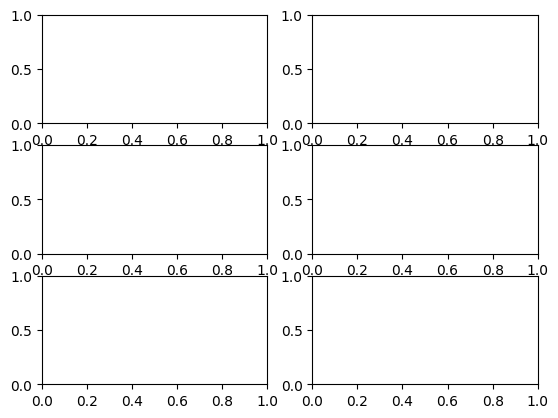

In [24]:
all_scores = pd.DataFrame(all_scores)

fig, axes = plt.subplots(3, 2)

for axes_, start in zip(axes, ('onset', 'offset')):
    for ax, level in zip( axes_, ('word', 'constituent', 'sentence')):
       sns.plot(ax=ax, x='times', y='score', data=all_scores.query('start==@start, level==@level'))

### #2
Second plot: same as the previous one, but averaged on subjects

###  #3
Now the same idea, but iterating on the targeted decoding: {word embedding, sentence embedding, etc..}

### #4 
Now baselined on offset, no matter whether it's on onset or offset window

### #5 
Submitit-compatible version

In [ ]:
!pip install submitit
import submitit

# Jitter test

In [24]:
import numpy as np 
import matplotlib.pyplot as plt

In [47]:
import mne_bids
import mne
from pathlib import Path
subject = '5'
run_id = 1
path = get_path("LPP_read")
task = "read"
print(f"\n Epoching for run {run_id}, subject: {subject}\n")
bids_path = mne_bids.BIDSPath(
    subject=subject,
    session="01",
    task=task,
    datatype="meg",
    root=path,
    run=run_id,
)

raw = mne_bids.read_raw_bids(bids_path)
raw.del_proj()  # To fix proj issues
raw.pick_types(meg=True, stim=True)

# Generate event_file path
event_file = path / f"sub-{bids_path.subject}"
event_file = event_file / f"ses-{bids_path.session}"
event_file = event_file / "meg"
event_file = str(event_file / f"sub-{bids_path.subject}")
event_file += f"_ses-{bids_path.session}"
event_file += f"_task-{bids_path.task}"
event_file += f"_run-{bids_path.run}_events.tsv"
assert Path(event_file).exists()

events = mne.find_events(raw, stim_channel="STI101", shortest_event=1)


 Epoching for run 1, subject: 5

Opening raw data file /home/co/data/BIDS_lecture/sub-5/ses-01/meg/sub-5_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 89000 ... 554999 =     89.000 ...   554.999 secs
Ready.
Reading events from /home/co/data/BIDS_lecture/sub-5/ses

/tmp/ipykernel_47264/512945526.py:18: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_47264/512945526.py:18: RuntimeWarning: Omitted 128 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_47264/512945526.py:18: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_47264/512945526.py:18: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1468 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


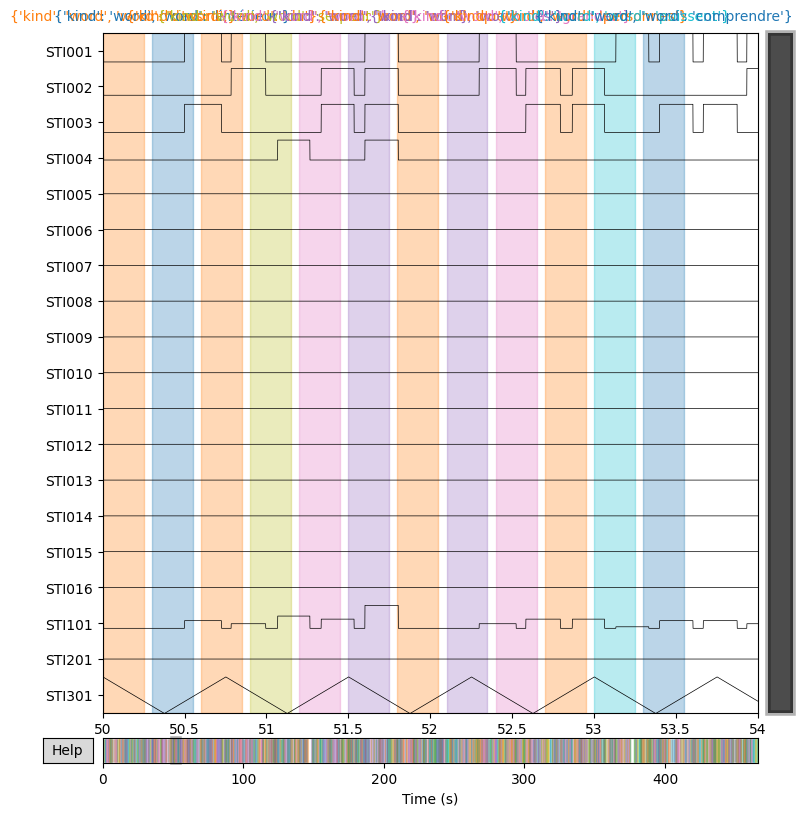

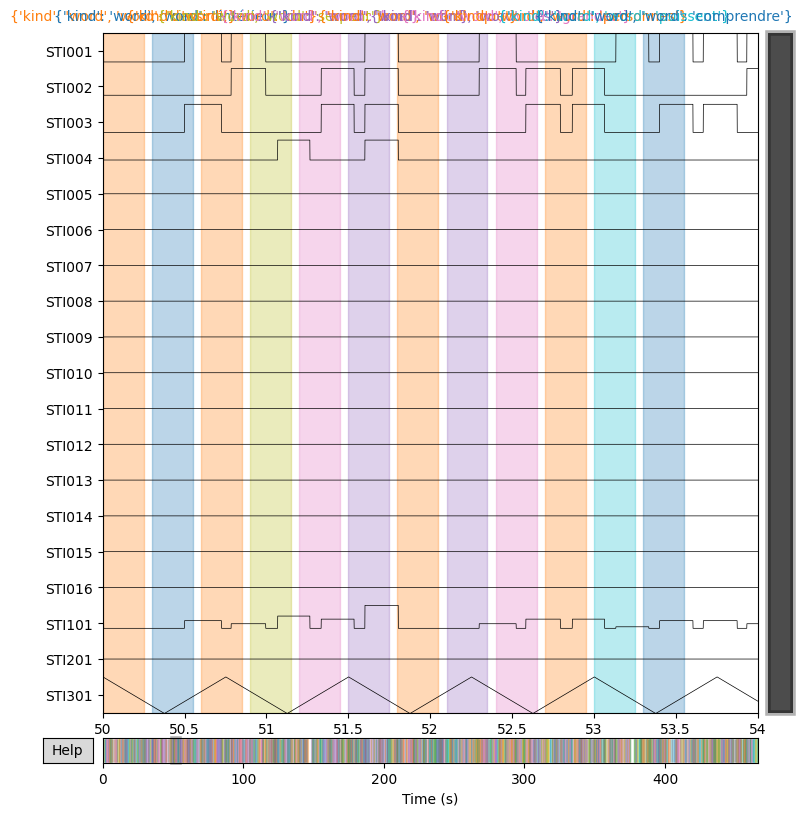

In [48]:
raw.copy().pick_types(meg=False, stim=True).plot(start=50, duration=4)

Trigger channel has a non-zero initial value of 8 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1466 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


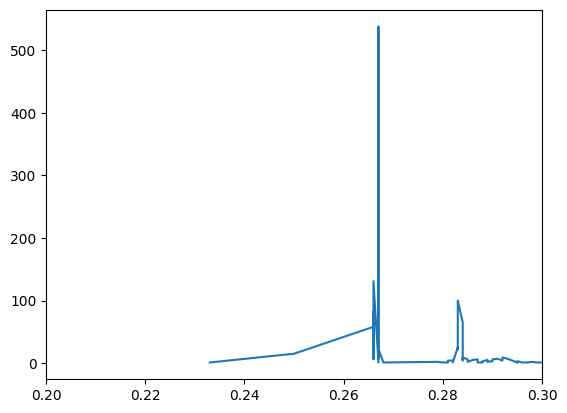

In [41]:
events = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
events_  = events[:,0] / raw.info["sfreq"]
diffs = np.diff(events_)
x,y = np.unique(diffs, return_counts=True)
plt.plot(x,y)
plt.xlim([0.2,0.3])
plt.show()


885 events found
Event IDs: [5]


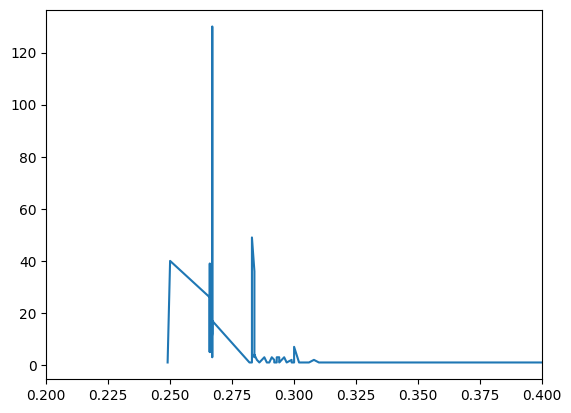

In [50]:
events = mne.find_events(raw, stim_channel="STI002", shortest_event=1)
events_  = events[:,0] / raw.info["sfreq"]
diffs = np.diff(events_)
x,y = np.unique(diffs, return_counts=True)
plt.plot(x,y)
plt.xlim([0.2,0.4])
plt.show()


In [5]:
import matplotlib.pyplot as plt

meta = epochs.metadata

SyntaxError: invalid syntax (3971304014.py, line 1)

# Testing decoding more and more difficult

In [1]:
from dataset import word_epochs_debug, get_path, get_subjects, sentence_epochs_debug
from utils import decod
from plot import plot_R
import mne

path = get_path("LPP_read")
subjects = get_subjects(path)
subjects = subjects[:2]

# WORDS
all_epochs = []
for sub in subjects:

    epochs = sentence_epochs_debug(sub, 3)
    all_epochs.append(epochs)

for epo in all_epochs:
    epo.info["dev_head_t"] = all_epochs[1].info["dev_head_t"]

epochs = mne.concatenate_epochs(all_epochs)


.
 Epoching for run 1, subject: 3

Opening raw data file /home/co/data/BIDS_lecture/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 36000 ... 517999 =     36.000 ...   517.999 secs
Ready.
Reading events from /home/co/data/BIDS_lecture/sub-3/se

/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Omitted 81 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Trigger channel has a non-zero initial value of 8 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1466 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Reading 0 ... 481999  =      0.000 ...   481.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.8s finished


ValueError: Length of values (134) does not match length of index (103)

In [2]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV
import numpy as np
from utils import correlate

def decod(X, y):
    assert len(X) == len(y)
    # define data
    model = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-1, 6, 10)))
    cv = KFold(15, shuffle=True, random_state=0)

    # fit predict
    n, n_chans, n_times = X.shape
    if y.ndim == 1:
        y = np.asarray(y).reshape(y.shape[0], 1)
    R = np.zeros((n_times, y.shape[1]))

    for t in range(n_times):
        print(".", end="")
        rs = []
        # y_pred = cross_val_predict(model, X[:, :, t], y, cv=cv)
        for train, test in cv.split(X):
            model.fit(X[train, :, t], y[train])
            y_pred = model.predict(X[test, :, t])
            r = correlate(y[test], y_pred)
            rs.append(r)
        R[t] = np.mean(rs)
        # R[t] = correlate(y, y_pred)


    return R

# LASER

In [3]:
from dataset import get_code_path

run_id = 1
CHAPTERS = {
1: "1-3",
2: "4-6",
3: "7-9",
4: "10-12",
5: "13-14",
6: "15-19",
7: "20-22",
8: "23-25",
9: "26-27",
}

meta = epochs.metadata

# # laser embeddings information
dim = 1024
embeds = np.fromfile(
    f"{get_code_path()}/data/laser_embeddings/emb_{CHAPTERS[int(run_id)]}.bin",
    dtype=np.float32,
    count=-1,
)
embeds.resize(embeds.shape[0] // dim, dim)
print(meta.shape[0])
embeds.shape


142


(134, 1024)

In [ ]:

epochs = epochs[]
X = epochs.get_data()
y = epochs.metadata.word.apply(len)
R_vec = decod(X, y)

## Word length

In [ ]:
# Remove the STIM information before decoding it (or else we'll get a 100% accuracy since the word length info is in the STIM channels)
epochs = epochs.pick_types(meg=True, stim=False, misc=False)
X = epochs.get_data()
y = epochs.metadata.word.apply(len)
R_vec = decod(X, y)

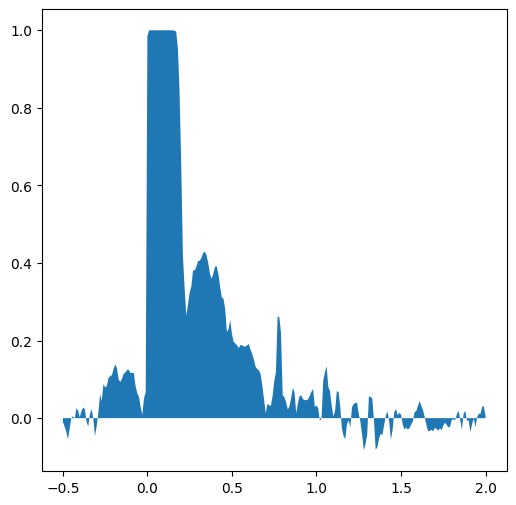

In [9]:
fig = plot_R(R_vec.reshape(-1))

import matplotlib.pyplot as plt
plt.show()


## Word embeddings

In [4]:
import spacy

nlp = spacy.load("fr_core_news_sm")
epochs = epochs.pick_types(meg=True, stim=False, misc=False)
X = epochs.get_data()
embeddings = epochs.metadata.word.apply(lambda word: nlp(word).vector).values
embeddings = np.array([emb for emb in embeddings])
R_vec = decod(X, embeddings)
R_vec = np.mean(R_vec, axis=1)

.......................................................................................................................................................

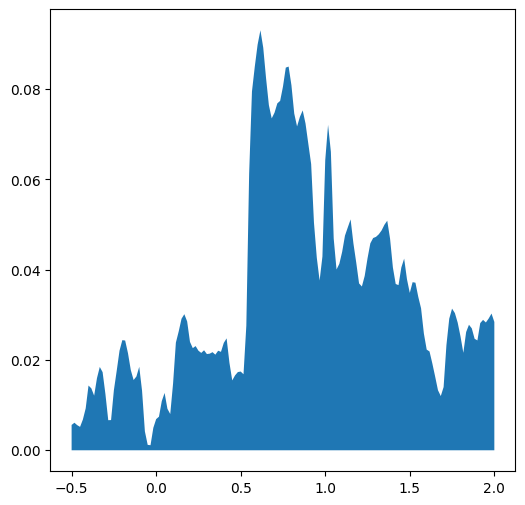

In [6]:
fig = plot_R(R_vec.reshape(-1))

import matplotlib.pyplot as plt
plt.show()


## Laser embeddings with JR baseline fix

In [9]:
sent_stop_data.shape
baseline_starts.shape

(164, 30)

Applying baseline correction (mode: mean)


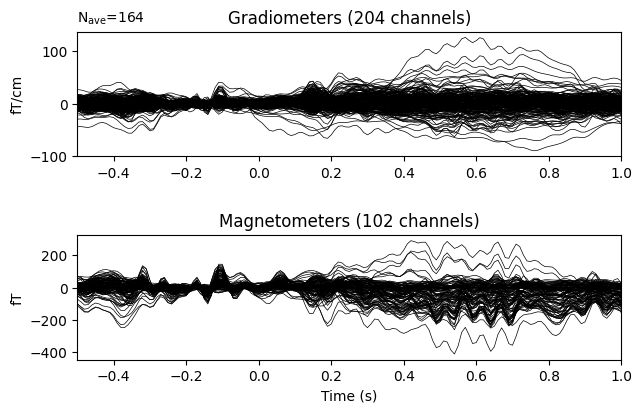

ValueError: operands could not be broadcast together with shapes (141,306,151) (164,30,1) (141,306,151) 

In [5]:
sent_starts = epochs['word_id==0'].apply_baseline((-.300, 0.))
sent_starts.average().plot()

sent_stops = epochs['is_last_word']
bsl = (epochs.times>-.300 )*(epochs.times<=0)
baseline_starts = sent_starts.get_data()[:, :, bsl].mean(-2)

sent_stop_data = sent_stops.get_data()
n_sentences, n_channels, n_times = sent_stop_data.shape
sent_stop_data -= baseline_starts[:, :, None]


## Others

  0%|          | 0/251 [00:00<?, ?it/s]

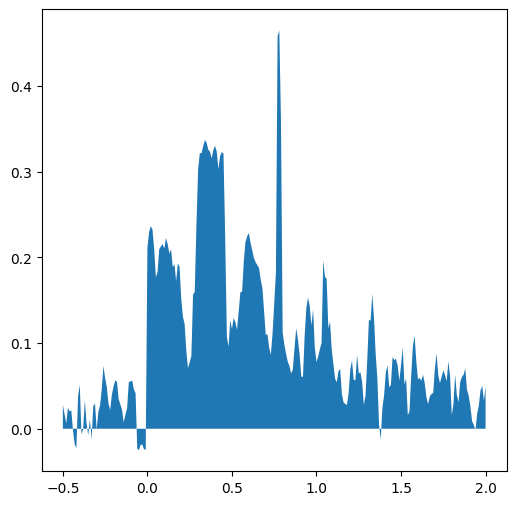

In [2]:
epochs.metaepochs.metadata.word.apply(len)
decoding_criterion = "n_closing"
R_vec = decod(epochs, decoding_criterion)

fig = plot_R(R_vec)

import matplotlib.pyplot as plt
plt.show()

# Generate plots

In [5]:
from dataset import get_path, get_subjects, word_epochs, sentence_epochs
import numpy as np
import matplotlib
import mne

matplotlib.use("Agg")

mne.set_log_level(False)


In [6]:
report = mne.Report()
path = get_path("LPP_read")
subjects = get_subjects(path)
task = "read"
evos = []

# WORDS
subjects = subjects[2]
epochs = word_epochs(subjects)

evo = epochs.average(method="median")
evos.append(evo)
evo.plot(spatial_colors=True)
report.add_evokeds(evo, titles=f"Evoked for condition word  ")


# SENTENCES
epochs = sentence_epochs(subjects)

evo = epochs.average(method="median")
evos.append(evo)
evo.plot(spatial_colors=True)
report.add_evokeds(evo, titles=f"Evoked for condition sentence  ")


evokeds = dict(sentence=evos[1], word=evos[0])

fig = mne.viz.plot_compare_evokeds(evokeds, combine="mean")

report.add_figure(fig, title="Evoked response comparaison")


report.save(
    f"./figures/{task}_sentvsword_test.html",
    open_browser=False,
    overwrite=True,
)






.
 Epoching for run 1, subject: 5



/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Omitted 128 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015

-0.5 1000.0
<class 'float'> <class 'float'>
-500.0
.
 Epoching for run 2, subject: 5



/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Omitted 134 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015

-0.5 1000.0
<class 'float'> <class 'float'>
-500.0
.
 Epoching for run 3, subject: 5



/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Omitted 130 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015

-0.5 1000.0
<class 'float'> <class 'float'>
-500.0
.
 Epoching for run 4, subject: 5



/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Omitted 128 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015

-0.5 1000.0
<class 'float'> <class 'float'>
-500.0
.
 Epoching for run 5, subject: 5



/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Omitted 136 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015

-0.5 1000.0
<class 'float'> <class 'float'>
-500.0
.
 Epoching for run 6, subject: 5



/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Omitted 134 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


-0.5 1000.0
<class 'float'> <class 'float'>
-500.0
.
 Epoching for run 7, subject: 5



/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Omitted 133 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015

-0.5 1000.0
<class 'float'> <class 'float'>
-500.0
.
 Epoching for run 8, subject: 5



/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Omitted 106 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:50: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015

-0.5 1000.0
<class 'float'> <class 'float'>
-500.0


/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:153: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(all_epochs)


In [ ]:
evo = epochs.average(method="median")
evo.plot(spatial_colors=True)

# Test new functions

In [1]:
from dataset import word_epochs

sub = '3'

epochs = word_epochs(sub)

.
 Epoching for run 1, subject: 3

Opening raw data file /home/co/data/BIDS_lecture/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 36000 ... 517999 =     36.000 ...   517.999 secs
Ready.
Reading events from /home/co/data/BIDS_lecture/sub-3/se

/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)


Reading channel info from /home/co/data/BIDS_lecture/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-01_channels.tsv.
Using 4 HPI coils: 293 307 314 321 Hz
Not fully anonymizing info - keeping his_id, sex, and hand info


/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Omitted 81 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Trigger channel has a non-zero initial value of 8 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1466 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Reading 0 ... 481999  =      0.000 ...   481.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   24.7s finished


Adding metadata with 13 columns
1411 matching events found
-0.5 1000.0
<class 'float'> <class 'float'>
-500.0
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1411 events and 2501 original time points (prior to decimation) ...
0 bad epochs dropped


IndexError: list index out of range


# Debug events

In [54]:
import mne_bids
from pathlib import Path
import pandas as pd
import mne
from utils import match_list
from dataset import mne_events
from utils import add_syntax


CHAPTERS = {
    1: "1-3",
    2: "4-6",
    3: "7-9",
    4: "10-12",
    5: "13-14",
    6: "15-19",
    7: "20-22",
    8: "23-25",
    9: "26-27",
}

In [61]:
path = get_path("LPP_read")
subjects = get_subjects(path)
run_id = 1
task = "read"
subject = '3'
baseline_min = -2.0
baseline_max = 0.5
epoch_on = 'sentence'
reference = "end"
print(f"\n Epoching for run {run_id}, subject: {subject}\n")
bids_path = mne_bids.BIDSPath(
    subject=subject,
    session="01",
    task=task,
    datatype="meg",
    root=path,
    run=run_id,
)

raw = mne_bids.read_raw_bids(bids_path)
raw.del_proj()  # To fix proj issues
raw.pick_types(meg=True, stim=True)
raw.load_data()
raw = raw.filter(0.5, 20)
# Generate event_file path
event_file = path / f"sub-{bids_path.subject}"
event_file = event_file / f"ses-{bids_path.session}"
event_file = event_file / "meg"
event_file = str(event_file / f"sub-{bids_path.subject}")
event_file += f"_ses-{bids_path.session}"
event_file += f"_task-{bids_path.task}"
event_file += f"_run-{bids_path.run}_events.tsv"
assert Path(event_file).exists()

# read events
meta = pd.read_csv(event_file, sep="\t")
events = mne.find_events(raw, stim_channel="STI101", shortest_event=1)


 Epoching for run 1, subject: 3

Opening raw data file /home/is153802/data/BIDS_lecture/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 36000 ... 517999 =     36.000 ...   517.999 secs
Ready.
Reading events from /home/is153802/data/BIDS_lectu

/tmp/ipykernel_78129/1263476122.py:20: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_78129/1263476122.py:20: RuntimeWarning: Omitted 81 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_78129/1263476122.py:20: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.2s finished


Trigger channel has a non-zero initial value of 8 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1466 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [62]:
meta_copy = meta.copy()

In [65]:
meta = meta_copy

In [66]:
path_syntax = get_code_path() / "data/syntax"

# Enriching the metadata with outside files:
meta = add_syntax(meta, path_syntax, int(run_id))

# Enriching the metadata with simple operations:

# end of sentence information
end_of_sentence = [
    True
    if str(meta.word.iloc[i]).__contains__(".")
    or str(meta.word.iloc[i]).__contains__("?")
    or str(meta.word.iloc[i]).__contains__("!")
    else False
    for i, _ in enumerate(meta.values[:-1])
]
end_of_sentence.append(True)
meta["sentence_end"] = end_of_sentence

# sentence start information
list_word_start = [True]
list_word_start_to_add = [
    True if meta.sentence_end.iloc[i - 1] else False
    for i in np.arange(1, meta.shape[0])
]
for boolean in list_word_start_to_add:
    list_word_start.append(boolean)
meta["sentence_start"] = list_word_start

# laser embeddings information
dim = 1024
embeds = np.fromfile(
    f"{get_code_path()}/data/laser_embeddings/emb_{CHAPTERS[int(run_id)]}.bin",
    dtype=np.float32,
    count=-1,
)
embeds.resize(embeds.shape[0] // dim, dim)
assert embeds.shape[0] == meta.shape[0]
meta["laser"] = [emb for emb in embeds]

# constituent end information
meta["constituent_end"] = [
        True if closing > 1 else False for i, closing in enumerate(meta.n_closing)]

# constituent start information
list_constituent_start = [True]
list_constituent_start_to_add = [
    True if meta.constituent_end.iloc[i - 1] else False
    for i in np.arange(1, meta.shape[0])
]
for boolean in list_constituent_start_to_add:
    list_constituent_start.append(boolean)
meta["constituent_start"] = list_constituent_start


AssertionError: 

In [67]:
# word_length_meg = events[:, 2]
word_len_meta = meta.word.apply(len)
i, j = match_list(word_len_meta, word_length_meg)
events = events[j]
assert len(i) / meta.shape[0] > 0.8
meta = meta.iloc[i].reset_index()

In [58]:
meta["start"] = events[:, 0] / raw.info["sfreq"]
meta["condition"] = "sentence"
meta = meta.sort_values("start").reset_index(drop=True)
meta["word_start"] = meta["start"]
meta["word_end"] = meta["word_start"] + meta["duration"]

epochs = mne.Epochs(
    raw, **mne_events(meta, raw), decim=20, tmin=baseline_min, tmax=baseline_max
)

Adding metadata with 20 columns
127 matching events found
Setting baseline interval to [-2.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


/tmp/ipykernel_78129/2931443479.py:7: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


In [59]:
meta

,index,Unnamed: 0,word,onset,duration,trial_type,n_closing,is_last_word,pos,content_word,sentence_end,sentence_start,laser,constituent_end,constituent_start,start,condition,word_start,word_end
0,21,21,vécues.,7.0,0.25,"{'kind': 'word', 'word': 'vécues'}",6,False,VPP,True,True,False,"[0.023229877, 0.024350138, -0.00015318407, 0.0...",True,True,55.853,sentence,55.853,56.103
1,30,30,fauve.,10.2,0.25,"{'kind': 'word', 'word': 'fauve'}",5,False,NC,True,True,False,"[0.022218416, -0.00034505766, 0.0015076251, 0....",True,True,58.564,sentence,58.564,58.814
2,35,35,dessin.,12.2,0.25,"{'kind': 'word', 'word': 'dessin'}",5,True,NC,True,True,False,"[-0.00026135266, 0.0016505849, -2.3930232e-05,...",True,True,61.548,sentence,61.548,61.798
3,51,51,mâcher.,17.5,0.25,"{'kind': 'word', 'word': 'mâcher'}",4,False,VINF,True,True,False,"[0.017938925, -0.00026753946, -5.8330224e-05, ...",True,True,63.064,sentence,63.064,63.314
4,93,93,dessin.,31.1,0.25,"{'kind': 'word', 'word': 'dessin'}",2,False,NC,True,True,False,"[0.035653125, 0.0017315869, 0.0013874767, 0.02...",True,True,63.881,sentence,63.881,64.131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1386,1386,"piquet.""",483.0,0.25,"{'kind': 'word', 'word': 'piquet'}",5,True,NC,True,True,False,"[0.021459103, -0.0008251642, -0.00013935748, 0...",True,True,509.004,sentence,509.004,509.254
123,1397,1397,d'idée!,487.3,0.25,"{'kind': 'word', 'word': 'didée'}",1,False,XXX,False,True,False,"[0.00049370097, 0.062676854, -0.00015987018, 0...",False,False,511.887,sentence,511.887,512.137
124,1425,1425,aille!,496.7,0.25,"{'kind': 'word', 'word': 'aille'}",5,True,VS,True,True,False,"[0.011370567, -6.920686e-05, 0.00038883876, 0....",True,True,512.421,sentence,512.421,512.671
125,1427,1427,où.,497.8,0.25,"{'kind': 'word', 'word': 'où'}",2,False,ADV,True,True,False,"[-0.000113535774, -0.00022956666, -0.000114733...",True,True,512.687,sentence,512.687,512.937


# Plotting decoding info

In [11]:
from plot import plot_subject

from dataset import get_path, get_subjects, get_code_path
import numpy as np
import matplotlib.pyplot as plt

In [16]:
task = "read"
sub = 4
epoch_on = 'sentence'
reference = "end"
min = -4.0
max = 0.5
decoding_criterion = 'laser'
path = get_code_path()
# Format the file path

# Open the pandas DataFrame containing the decoding values
R = np.load(
    (path) / f"decoding/results/{task}/decoding_{decoding_criterion}_{epoch_on}_{reference}_{sub}.npy"
)

In [17]:
R

array([0.94571566, 0.9496402 , 0.94734374, 0.95004925, 0.94905952,
       0.95072931, 0.949452  , 0.94713672, 0.95421145, 0.94594563,
       0.94744584, 0.94862037, 0.94928338, 0.94916964, 0.95020626,
       0.94825326, 0.94870474, 0.95113422, 0.95330275, 0.9517745 ,
       0.94970269, 0.94619953, 0.95142225, 0.94584023, 0.94584851,
       0.94472265, 0.94640807, 0.94643646, 0.94582556, 0.94662353,
       0.94890851, 0.94898927, 0.94759754, 0.94485033, 0.94620731,
       0.94747578, 0.9495102 , 0.94889217, 0.95069399, 0.9492606 ,
       0.94661907, 0.95189438, 0.94979348, 0.95097936, 0.95118893,
       0.948757  , 0.94722428, 0.94624425, 0.95163316, 0.94797564,
       0.94356263, 0.94723742, 0.94847994, 0.94922971, 0.95086979,
       0.94546894, 0.94813044, 0.94425016, 0.9472708 , 0.94688154,
       0.94849403, 0.94572721, 0.94723052, 0.94683588, 0.95055899,
       0.9433849 , 0.94863104, 0.94545493, 0.94581869, 0.94638482,
       0.94848757, 0.95032514, 0.94788461, 0.94592985, 0.95119

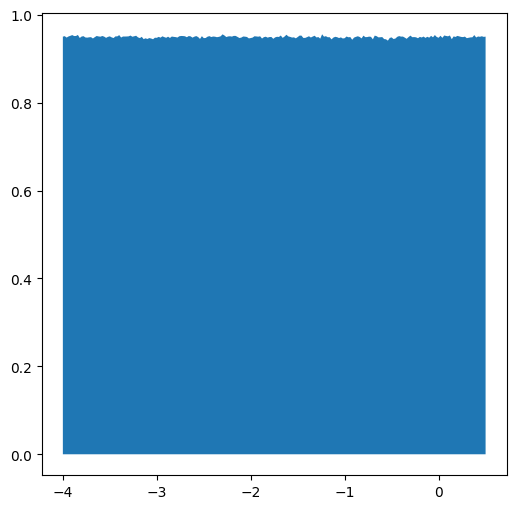

In [14]:
times = np.linspace(min, max, R.shape[0])  # To do better at generalizing
fig, ax = plt.subplots(1, figsize=[6, 6])
dec = plt.fill_between(times, R)

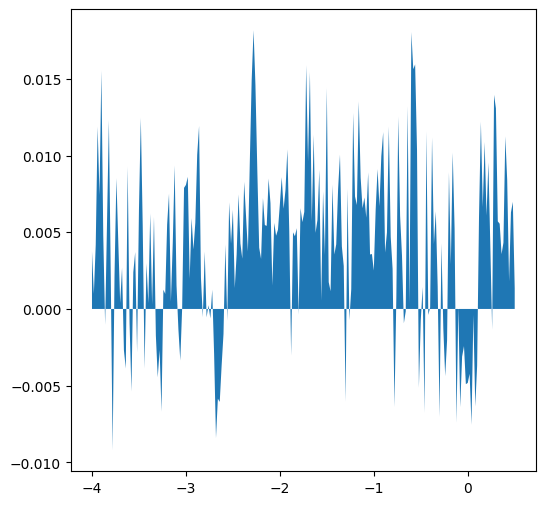

In [4]:
task = "read"
sub = 3
epoch_on = 'sentence'
reference = "end"
min = -4.0
max = 0.5
decoding_criterion = 'laser'
plot = plot_subject(sub, decoding_criterion, task, reference, epoch_on, min, max)

# Debugging ERP plots

In [27]:
path = get_path("LPP_read")
subjects = get_subjects(path)
RUN = 1
baseline_min = -1.0
baseline_max = 1.0
task = "read"

subjects = subjects[10]
epochs2 = epoch_subjects(
    subjects, RUN, task, path, baseline_max=baseline_max, baseline_min=baseline_min
)

epochs2

.
 Epoching for run 01, subject: 1



/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:97: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:97: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:97: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.rea

.
 Epoching for run 01, subject: 1



/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:198: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:282: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


Number of events,254
Events,1: 254
Time range,-1.000 – 1.000 sec
Baseline,-1.000 – 0.000 sec


In [28]:
epochs2.metadata

,level_0,index,Unnamed: 0,word,onset,duration,trial_type,n_closing,is_last_word,pos,...,sentence_start,laser,constituent_end,constituent_start,start,condition,word_start,word_end,label,kind
0,0,21,21,vécues,8.05,0.3,"{'kind': 'word', 'word': 'vécues'}",6,False,VPP,...,False,"[0.023229877, 0.024350138, -0.00015318407, 0.0...",True,True,44.534,sentence,44.534,44.834,run_1,word
1,1,30,30,fauve,11.20,0.3,"{'kind': 'word', 'word': 'fauve'}",5,False,NC,...,False,"[0.022218416, -0.00034505766, 0.0015076251, 0....",True,True,47.706,sentence,47.706,48.006,run_1,word
2,2,35,35,dessin,12.95,0.3,"{'kind': 'word', 'word': 'dessin'}",5,True,NC,...,False,"[-0.00026135266, 0.0016505849, -2.3930232e-05,...",True,True,51.172,sentence,51.172,51.472,run_1,word
3,3,51,51,mâcher,18.55,0.3,"{'kind': 'word', 'word': 'mâcher'}",4,False,VINF,...,False,"[0.017938925, -0.00026753946, -5.8330224e-05, ...",True,True,52.606,sentence,52.606,52.906,run_1,word
4,4,93,93,dessin,33.25,0.3,"{'kind': 'word', 'word': 'dessin'}",2,False,NC,...,False,"[0.035653125, 0.0017315869, 0.0013874767, 0.02...",True,True,53.556,sentence,53.556,53.856,run_1,word
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,122,1386,1386,piquet,485.80,0.3,"{'kind': 'word', 'word': 'piquet'}",5,True,NC,...,False,"[0.021459103, -0.0008251642, -0.00013935748, 0...",True,True,523.478,sentence,523.478,523.778,run_1,word
250,123,1397,1397,didée,489.65,0.3,"{'kind': 'word', 'word': 'didée'}",1,False,XXX,...,False,"[0.00049370097, 0.062676854, -0.00015987018, 0...",False,False,526.478,sentence,526.478,526.778,run_1,word
251,124,1425,1425,aille,499.45,0.3,"{'kind': 'word', 'word': 'aille'}",5,True,VS,...,False,"[0.011370567, -6.920686e-05, 0.00038883876, 0....",True,True,527.111,sentence,527.111,527.411,run_1,word
252,125,1427,1427,où,500.15,0.3,"{'kind': 'word', 'word': 'où'}",2,False,ADV,...,False,"[-0.000113535774, -0.00022956666, -0.000114733...",True,True,527.428,sentence,527.428,527.728,run_1,word


In [11]:
# Homemade imports
from dataset import get_path, get_subjects, epoch_subjects, epochs_slice
from plot import plot_subject

# General imports
import numpy as np
import mne
import hydra
from omegaconf import DictConfig
import matplotlib

matplotlib.use("Agg")

mne.set_log_level(False)

# Later: integrate Hydra here as well. For now, just simple plotting of ERPS

report = mne.Report()
path = get_path("LPP_read")
subjects = get_subjects(path)
RUN = 1
baseline_min = -1.0
baseline_max = 1.0
task = "read"
print("\nSubjects for which the plotting will be done: \n")
print(subjects)

# DEBUG
subjects = subjects[4]
epochs_ = epoch_subjects(
    subjects, RUN, task, path, baseline_max=baseline_max, baseline_min=baseline_min
)






# Build a 3x2 plot, with for each condition (sentence, word, constituent), and for (start, end),
# the ERP associated
cond = ["sentence", "word", "constituent"]
cases = {"start", "end"}

# Plotting and adding to the report, the averaged ERPs of:
# words, sentences and constituents, centered at the beginning and end of each


# Need to map for:
# - end of word,
# - beginning of sentence (epochs[i+1] !danger limits)
# - beginning of constituent (epochs[i+1] !same danger)

evos = []
for condi in cond:
    for case in cases:
        # Slice the epochs based on the epoch_criterion:
        column_to_slice_on = f"{condi}_{case}"
        if condi == "sentence" or condi == "word":  # eg: {sentence}_{end} or {word}_{start}
            epochs = epochs_slice(epochs_, column_to_slice_on)
        elif condi == "constituent":
            epochs = epochs_slice(epochs_, column_to_slice_on, value=2, equal='sup')
        evo = epochs.average(method="median")
        evos.append(evo)
        evo.plot(spatial_colors=True)
        report.add_evokeds(evo, titles=f"Evoked for condition {column_to_slice_on}  ")

evokeds = dict(sentence=evos[0], word=evos[2], constituent=evos[4])

fig = mne.viz.plot_compare_evokeds(evokeds, combine="mean")

report.add_figure(fig, title="Evoked response comparaison")


report.save(
    f"./figures/{task}_ERP_all_cond.html",
    open_browser=False,
    overwrite=True,
)


Subjects for which the plotting will be done: 

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
.
 Epoching for run 01, subject: 5



/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:97: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:97: RuntimeWarning: Omitted 128 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:97: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/readi

ValueError: Some of the values  to be plotted are NaN.

In [12]:
epochs_

Number of events,127
Events,1: 127
Time range,-1.000 – 1.000 sec
Baseline,-1.000 – 0.000 sec


In [25]:
ep = epochs_slice(epochs_, 'sentence_start')

In [26]:
ep

Number of events,5
Events,1: 5
Time range,-1.000 – 1.000 sec
Baseline,-1.000 – 0.000 sec


In [19]:
ep

Number of events,5
Events,1: 5
Time range,-1.000 – 1.000 sec
Baseline,-1.000 – 0.000 sec


In [1]:
from plot import plot_subject

from dataset import get_path, get_subjects

In [3]:
path = get_path("LPP_read")
subjects = get_subjects(path)
run = 1
task = "read"
subject = '17'
baseline_min = -2.0
baseline_max = 0.5
epoch_on = 'sentence'
reference = "end"

In [4]:
from dataset import epoch_data
epo = epoch_data(
    subject,
    run,
    task,
    path,
    baseline_min,
    baseline_max,
)


 Epoching for run 1, subject: 17

Opening raw data file /home/is153802/data/BIDS_lecture/sub-17/ses-01/meg/sub-17_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 6000 ... 474999 =      6.000 ...   474.999 secs
Ready.
Reading events from /home/is153802/data/BIDS_lec

/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:97: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:97: RuntimeWarning: Omitted 120 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:97: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/readi

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.9s finished


1466 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Adding metadata with 20 columns
127 matching events found
Setting baseline interval to [-2.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 127 events and 2501 original time points (prior to decimation) ...


/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:198: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped


In [5]:
from dataset import epochs_slice
epos = epochs_slice(epo, 'sentence_end')

In [6]:
epos

Number of events,127
Events,1: 127
Time range,-2.000 – 0.500 sec
Baseline,-2.000 – 0.000 sec


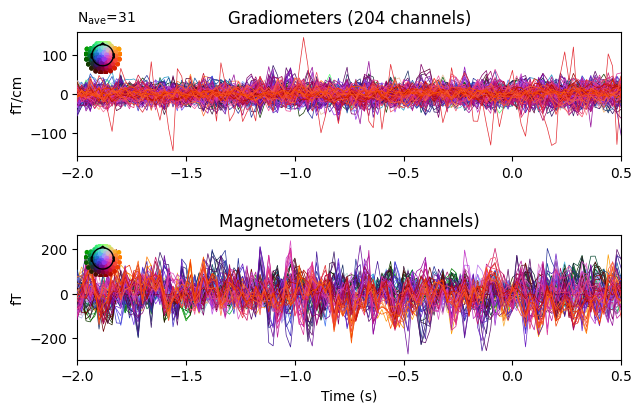

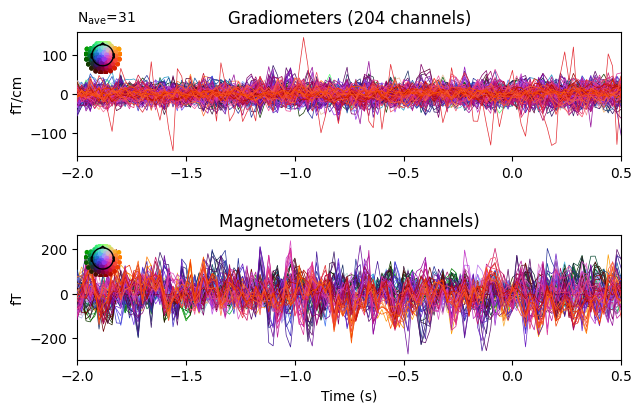

In [25]:
evo = epos.average(method="median")
evo.plot()

# GFP for sentence - epoching on sentence end and go from there

In [47]:
# Homemade imports
from dataset import get_path, get_subjects, epoch_runs
from plot import plot_subject

# General imports
import numpy as np
import mne
import hydra
from omegaconf import DictConfig
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from wordfreq import zipf_frequency
from Levenshtein import editops

# Tools
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib
from utils import match_list, add_syntax
import spacy

In [16]:
path = get_path("LPP_read")
subjects = get_subjects(path)
RUN = 2
task = "read"
subject = subjects[1]
baseline_min = -4.0
baseline_max = 0.5
epoch_on = 'sentence'
reference = "end"

In [17]:
epochs = epoch_runs(
            subject,
            RUN,
            task,
            path,
            baseline_min,
            baseline_max,
            epoch_on=epoch_on,
            reference=reference,
        )

.
 Epoching for run 01, subject: 2

Opening raw data file /home/co/data/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 22000 ... 491999 =     22.000 ...   491.999 secs
Ready.
Reading events from /home/co/data/BIDS_lecture/sub-2/s

/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: Omitted 117 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1467 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063]


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.5s finished


      index  Unnamed: 0     word  onset  duration  \
0         0           0  Lorsque    0.7      0.25   
1         1           1  j'avais    1.0      0.25   
2         2           2      six    1.3      0.25   
3         3           3     ans,    1.6      0.25   
4         4           4     j'ai    1.9      0.25   
...     ...         ...      ...    ...       ...   
1406   1459        1459       ne  508.9      0.25   
1407   1460        1460     peut  509.2      0.25   
1408   1461        1461      pas  509.5      0.25   
1409   1462        1462    aller  509.8      0.25   
1410   1463        1463     bien  510.1      0.25   

                               trial_type    start condition  n_closing  \
0     {'kind': 'word', 'word': 'Lorsque'}   23.752  sentence          1   
1      {'kind': 'word', 'word': 'javais'}   24.052  sentence          1   
2         {'kind': 'word', 'word': 'six'}   24.302  sentence          1   
3         {'kind': 'word', 'word': 'ans'}   24.585  sentence   

/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:226: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
.
 Epoching for run 02, subject: 2

Opening raw data file /home/co/data/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-read_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 26000 ... 528999 =     26.000 ...   528.999 secs
Ready.
Reading events from /home/co/data

/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: Omitted 146 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1607 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063 2064]


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.5s finished


      index  Unnamed: 0      word  onset  duration  \
0         0           0   J'avais    0.7      0.25   
1         1           1     ainsi    1.0      0.25   
2         2           2    appris    1.3      0.25   
3         3           3       une    1.6      0.25   
4         4           4   seconde    1.9      0.25   
...     ...         ...       ...    ...       ...   
1557   1599        1599     petit  551.9      0.25   
1558   1600        1600    prince  552.2      0.25   
1559   1601        1601        ne  552.5      0.25   
1560   1602        1602  répondit  552.8      0.25   
1561   1603        1603      pas.  553.1      0.25   

                                trial_type    start condition  n_closing  \
0       {'kind': 'word', 'word': 'Javais'}   28.461  sentence          1   
1        {'kind': 'word', 'word': 'ainsi'}   28.763  sentence          1   
2       {'kind': 'word', 'word': 'appris'}   29.013  sentence          2   
3          {'kind': 'word', 'word': 'une'}   29

AssertionError: 

In [34]:
run = 1
from dataset import epoch_data
epo = epoch_data(
    subject,
    run,
    task,
    path,
    baseline_min=-0.2,
    baseline_max=0.8,
    filter=True,
    epoch_on="word",
    reference="end",
)


 Epoching for run 2, subject: 2

Opening raw data file /home/co/data/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-read_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 26000 ... 528999 =     26.000 ...   528.999 secs
Ready.
Reading events from /home/co/data/BIDS_lecture/sub-2/ses

/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: Omitted 146 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1607 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063 2064]


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.7s finished


Adding metadata with 14 columns
1562 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1562 events and 1001 original time points (prior to decimation) ...


/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:226: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped


In [38]:
meta = epo.metadata

In [40]:

meta[50:100]

,level_0,index,Unnamed: 0,word,onset,duration,trial_type,start,condition,n_closing,is_last_word,pos,content_word,sentence_end
50,50,50,50,des,16.7,0.25,"{'kind': 'word', 'word': 'des'}",43.130,sentence,1,False,DET,False,False
51,51,51,51,centaines,17.0,0.25,"{'kind': 'word', 'word': 'centaines'}",43.396,sentence,1,False,NC,True,False
52,52,52,52,d'autres,17.3,0.25,"{'kind': 'word', 'word': 'dautres'}",43.663,sentence,1,False,XXX,False,False
53,53,53,53,qui,17.6,0.25,"{'kind': 'word', 'word': 'qui'}",43.929,sentence,2,False,PROREL,False,False
54,54,54,54,sont,17.9,0.25,"{'kind': 'word', 'word': 'sont'}",44.213,sentence,2,False,V,True,False
55,55,55,55,quelquefois,18.2,0.25,"{'kind': 'word', 'word': 'quelquefois'}",44.480,sentence,1,False,ADV,True,False
56,56,56,56,si,18.5,0.25,"{'kind': 'word', 'word': 'si'}",44.746,sentence,1,False,ADV,True,False
57,57,57,57,petites,18.8,0.25,"{'kind': 'word', 'word': 'petites'}",45.013,sentence,1,False,ADJ,True,False
58,58,58,58,qu'on,19.1,0.25,"{'kind': 'word', 'word': 'quon'}",45.279,sentence,1,False,XXX,False,False
59,59,59,59,a,19.4,0.25,"{'kind': 'word', 'word': 'a'}",45.563,sentence,1,False,V,True,False


In [70]:
from dataset import get_code_path, get_path, mne_events

run_id = RUN
epoch_on = 'word'
reference = "start"

CHAPTERS = {
    1: "1-3",
    2: "4-6",
    3: "7-9",
    4: "10-12",
    5: "13-14",
    6: "15-19",
    7: "20-22",
    8: "23-25",
    9: "26-27",
}


bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=RUN,
    )

raw = mne_bids.read_raw_bids(bids_path)
raw.del_proj()  # To fix proj issues
raw.pick_types(meg=True, stim=True)
raw.load_data()
raw = raw.filter(0.5, 20)
# Generate event_file path
event_file = path / f"sub-{bids_path.subject}"
event_file = event_file / f"ses-{bids_path.session}"
event_file = event_file / "meg"
event_file = str(event_file / f"sub-{bids_path.subject}")
event_file += f"_ses-{bids_path.session}"
event_file += f"_task-{bids_path.task}"
event_file += f"_run-{bids_path.run}_events.tsv"
assert Path(event_file).exists()

# read events
meta = pd.read_csv(event_file, sep="\t")
events = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
if (
    bids_path.task == "read" and bids_path.subject == "2"
):  # A trigger value bug for this subject
    word_length_meg = (
        events[:, 2] - 2048
    )  # Remove first event: chapter start and remove offset
else:
    word_length_meg = events[:, 2]
# Here, the trigger value encoded the word length
# which helps us realign triggers
# From the event file / from the MEG events
word_len_meta = meta.word.apply(len)
i, j = match_list(word_len_meta, word_length_meg)
events = events[j]
meta = meta.iloc[i].reset_index()
print(meta.shape)
# The start parameter will help us
# keep the link between raw events and metadata
meta["start"] = events[:, 0] / raw.info["sfreq"]
meta["condition"] = "sentence"
meta = meta.sort_values("start").reset_index(drop=True)

# Raw LPP textual data
path_txt = get_code_path() / "data/txt_raw"
# LPP Syntax data
path_syntax = get_code_path() / "data/syntax"

# Enriching the metadata with outside files:
meta = add_syntax(meta, path_syntax, int(run_id))
print(meta.shape)
# Add the information on the sentence ending:
# Only works for reading: TO FIX for listening... to see with Christophe
# Also: only works for v2 (subject 1 (me) doesn't work )

# Test 1
# end_of_sentence = [
#     True if meta.onset.iloc[i + 1] - meta.onset.iloc[i] > 0.7 else False
#     for i, _ in enumerate(meta.values[:-1])
# ]
# end_of_sentence.append(True)

# Test 2
end_of_sentence = [
    True
    if str(meta.word.iloc[i]).__contains__(".")
    or str(meta.word.iloc[i]).__contains__("?")
    or str(meta.word.iloc[i]).__contains__("!")
    else False
    for i, _ in enumerate(meta.values[:-1])
]
end_of_sentence.append(True)
meta["sentence_end"] = end_of_sentence

# We are considering different cases:
# Are we epoching on words, sentences, or constituents?
# Different epoching for different analysis
if epoch_on == "word" and reference == "start":
    # Default case, so nothing to change
    # Could be removed but kept for easy of reading
    happy = True
# Word end
if epoch_on == "word" and reference == "end":
    # Little hack: not really pretty but does the job
    # As epoching again uses the start column, we rename it like that
    # But it should be meta["end"] instead...
    meta["start"] = [row["start"] + row["duration"] for i, row in meta.iterrows()]

# Sentence end
elif epoch_on == "sentence" and reference == "end":
    # Add a LASER embeddings column for decoding
    dim = 1024
    embeds = np.fromfile(
        f"{get_code_path()}/data/laser_embeddings/emb_{CHAPTERS[int(run_id)]}.bin",
        dtype=np.float32,
        count=-1,
    )
    embeds.resize(embeds.shape[0] // dim, dim)
    column = "sentence_end"
    value = True
    meta = meta[meta[column] == value]
    # TODO: create a match list between the embeds sentence and the
    print(embeds.shape[0], meta.shape[0])
    assert embeds.shape[0] == meta.shape[0]
    meta["laser"] = [emb for emb in embeds]
    print("Added embeddings")
# Sentence start
elif epoch_on == "sentence" and reference == "start":
    # Create a sentence-start column:
    # list_word_start = [
    #     True
    #     for i, is_last_word in enumerate(meta.is_last_word[:-1])
    #     if meta.is_last_word[i + 1]
    # ]
    list_word_start = [True]
    list_word_start_to_add = [
        True if meta.sentence_end[i - 1] else False
        for i, _ in enumerate(meta.sentence_end[1:])
    ]
    for boolean in list_word_start_to_add:
        list_word_start.append(boolean)
    meta["sentence_start"] = list_word_start
    column = "sentence_start"
    value = True
    meta = meta[meta[column] == value]
# Constituent start
elif epoch_on == "constituent" and reference == "start":
    # Create a constituent-start column:
    meta["constituent_start"] = [
        True for i, _ in enumerate(meta.is_last_word[1:]) if meta.n_closing > 1
    ]
    column = "constituent_start"
    value = True
    meta = meta[meta[column] == value]
# Constituent end
elif epoch_on == "constituent" and reference == "end":
    # Create a constituent-start column:
    meta["constituent_start"] = [
        True for i, _ in enumerate(meta.is_last_word[1:]) if meta.n_closing > 1
    ]
    column = "constituent_start"
    value = True
    meta = meta[meta[column] == value]
epochs = mne.Epochs(
    raw, **mne_events(meta, raw), decim=20, tmin=baseline_min, tmax=baseline_max
)
# epochs = epochs['kind=="word"']
# epochs.metadata["closing"] = epochs.metadata.closing_.fillna(0)
epochs.load_data()
epochs = epochs.pick_types(meg=True, stim=False, misc=False)
data = epochs.get_data()

# Scaling the data
n_words, n_chans, n_times = data.shape
vec = data.transpose(0, 2, 1).reshape(-1, n_chans)
scaler = RobustScaler()
idx = np.arange(len(vec))
np.random.shuffle(idx)
vec = scaler.fit(vec[idx[:20_000]]).transform(vec)
# To try: sigmas = 7 or 15
sigma = 7
vec = np.clip(vec, -sigma, sigma)
epochs._data[:, :, :] = (
    scaler.inverse_transform(vec)
    .reshape(n_words, n_times, n_chans)
    .transpose(0, 2, 1)
)

Opening raw data file /home/co/data/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-read_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 26000 ... 528999 =     26.000 ...   528.999 secs
Ready.
Reading events from /home/co/data/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-read_run

/tmp/ipykernel_71726/3950605263.py:29: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_71726/3950605263.py:29: RuntimeWarning: Omitted 146 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_71726/3950605263.py:29: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_71726/3950605263.py:29: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    5.6s finished


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1607 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063 2064]
(1562, 6)
(1562, 12)
Adding metadata with 14 columns
1562 matching events found
Setting baseline interval to [-4.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1562 events and 4501 original time points (prior to decimation) ...


/tmp/ipykernel_71726/3950605263.py:169: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


6 bad epochs dropped


In [73]:
meta[50:100]

,index,Unnamed: 0,word,onset,duration,trial_type,start,condition,n_closing,is_last_word,pos,content_word,sentence_end
50,50,50,des,16.7,0.25,"{'kind': 'word', 'word': 'des'}",42.880,sentence,1,False,DET,False,False
51,51,51,centaines,17.0,0.25,"{'kind': 'word', 'word': 'centaines'}",43.146,sentence,1,False,NC,True,False
52,52,52,d'autres,17.3,0.25,"{'kind': 'word', 'word': 'dautres'}",43.413,sentence,1,False,XXX,False,False
53,53,53,qui,17.6,0.25,"{'kind': 'word', 'word': 'qui'}",43.679,sentence,2,False,PROREL,False,False
54,54,54,sont,17.9,0.25,"{'kind': 'word', 'word': 'sont'}",43.963,sentence,2,False,V,True,False
55,55,55,quelquefois,18.2,0.25,"{'kind': 'word', 'word': 'quelquefois'}",44.230,sentence,1,False,ADV,True,False
56,56,56,si,18.5,0.25,"{'kind': 'word', 'word': 'si'}",44.496,sentence,1,False,ADV,True,False
57,57,57,petites,18.8,0.25,"{'kind': 'word', 'word': 'petites'}",44.763,sentence,1,False,ADJ,True,False
58,58,58,qu'on,19.1,0.25,"{'kind': 'word', 'word': 'quon'}",45.029,sentence,1,False,XXX,False,False
59,59,59,a,19.4,0.25,"{'kind': 'word', 'word': 'a'}",45.313,sentence,1,False,V,True,False


In [57]:
j.shape

(1562,)

In [74]:
events.shape

(1562, 3)

In [77]:
events_2 = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
events_2.shape

Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1607 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063 2064]


(1607, 3)

In [64]:
b.shape

(1562,)

In [ ]:
epochs.metadata

In [ ]:
from utils import decod
R_vec = decod(epochs, decoding_criterion)

In [ ]:
import matplotlib.pyplot as plt
plt.fill_between(epochs.times, R_vec)

In [ ]:
epochs.metadata

In [ ]:
np.diff(epochs.metadata.onset)

In [ ]:
epochs2 = epoch_runs(subject, RUN, task, path, baseline_min,baseline_max)

x 
x 
x 
x 
x 
x 
x 
x 
x 

In [ ]:
arr = np.round(np.diff(epochs2.metadata.onset),3)
unique, counts = np.unique(arr, return_counts=True)

# Print unique values and their counts
for val, count in zip(unique, counts):
    print(f"{val} occurs {count} times.")


In [ ]:
sum(np.diff(epochs2.metadata.onset)>0.7)

In [ ]:
evo = epochs.average(method="median")
evo.plot(gfp='only')

In [ ]:
epochs.events

In [ ]:
def epochs_(epochs, column, value):
    meta  = epochs.metadata
    subset = meta[meta[column]==value].level_0
    return epochs[subset]


In [ ]:
epochs.metadata['n_closing'][:50]

In [ ]:
epochs_(epochs,'is_last_word',True)

In [ ]:
import matplotlib.pyplot as plt
# Build a 3x2 plot, with for each condition (sentence, word, constituent), and for (start, end),
# the ERP associated
cond = {'sentence': {'column':'is_last_word','target':True},
        'word': {'column':'kind','target':'word'},
        'constituent': {'column':'n_closing','target':2}}

cases = {'start', 'end'}

i = 1
for condi in cond:
    for case in cases:
        ep = epochs_(epochs, cond[condi]['column'], cond[condi]['target'])
        ax = fig.add_subplot(3, 2, i)
        #ep.average().plot(gfp='only')
        evo = ep.average(method="median")
        evo.plot(spatial_colors=True)
        i = i + 1
        ax.set_title(f'Plot {cond}')


plt.show()


In [ ]:
epochs_4 = epochs_(epochs, 'n_closing', 4)

In [ ]:
epochs_4.average().plot(gfp='only')

In [ ]:
evo = epochs.average(method="median")
evo.plot(spatial_colors=True)

In [ ]:
metadata_subset

In [ ]:
from mne import Epochs

class CustomEpochs(Epochs):

    def __getitem__(self, key):
        # Parse the key into metadata field name and value
        field, value = key.split('==')
        field = field.strip()
        value = value.strip()

        # Get the indices of the epochs that match the metadata query
        indices = [i for i, metadata in enumerate(self.metadata[field]) if metadata == value]

        # Return a new Epochs object containing only the matching epochs
        return self.__class__(self._data[indices], self.events[indices], self.event_id,
                              tmin=self.tmin, tmax=self.tmax, baseline=self.baseline,
                              metadata=self.metadata.iloc[indices], info=self.info)



In [ ]:
custom_epochs = CustomEpochs(epochs, epochs.events, "1", -0.2, 0.8, epochs.baseline, epochs.metadata)

# Get all epochs where the 'kind' metadata field is 'word':
word_epochs = custom_epochs['kind==word']

In [ ]:
custom_epochs['kind=="word"']

In [ ]:
# epoch
def mne_events(meta):
    events = np.ones((len(meta), 3), dtype=int)
    events[:, 0] = meta.start*raw.info['sfreq']
    return dict(events=events, metadata=meta.reset_index())

epochs = mne.Epochs(raw, **mne_events(meta), decim=20, tmin=-.2, tmax=1.5, preload=True)
epochs = epochs['kind=="word"']

In [ ]:
from dataset import get_path, get_subjects, epoch_data, epoch_runs
from utils import (
    decod,
    correlate,
    match_list,
    create_target,
    analysis,
    save_decoding_results,
)
from plot import plot_subject
import mne_bids
from pathlib import Path
import pandas as pd
import numpy as np
import mne
import spacy
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV
from wordfreq import zipf_frequency
from Levenshtein import editops
import matplotlib.pyplot as plt

In [ ]:
path = get_path("LPP_read")
subjects = get_subjects(path)
RUN = 9
task = "read"
subject = subjects[4]

In [ ]:
epochs = epoch_runs(subject, RUN, task, path)

In [ ]:
(epochs.metadata).dtype

In [ ]:
epochs.load_data()
epochs = epochs['kind=="word"']
epochs["content_word == False"]